In [163]:
dataFolder = '../../Data/plaintext_articles/'
dataFolder2 = 'Data/wikispeedia_paths-and-graph/'
from sklearn.feature_extraction.text import CountVectorizer
import os 
import numpy as np
from sklearn import metrics
import pandas as pd
from urllib.parse import unquote
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
from statsmodels.stats import diagnostic
from sklearn.cluster import KMeans
import math
import spacy, nltk, gensim, sklearn
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats
from statsmodels.stats import diagnostic
import networkx as nx
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf

Let start by evaluating the effectiveness of the TF-IDF (Term Frequency-Inverse Document Frequency) matrix. Our objective is to determine whether this approach can successfully identify distinct clusters (White and Others) within the plaintext content of Wikipedia articles.

In [164]:
people_skin_color = pd.read_csv(dataFolder2 + 'ethnic_category.tsv', header=1, sep= '\t' )
people_skin_color.columns = ['Category', 'People', 'Skin Color']
people_skin_color['People'] = people_skin_color['People'].map(lambda x : x.replace("%20", "_"))

In [165]:
corpus = []
titles =[]
for title in people_skin_color['People'] : 
    corpus.append(dataFolder+title+'.txt')
    titles.append(title)
len(corpus)

711

In [166]:
df = pd.DataFrame(data = titles, columns = ['People'])
df['Skin Color'] = people_skin_color['Skin Color']
df['Skin Color' ] = df['Skin Color'].apply(lambda x : 'Others' if x != 'White' else x)

In [167]:
#TF_IDF Matrix

In [168]:
tdfVectorizer = TfidfVectorizer(
    input = 'filename',
    max_df=0.5,
    min_df=1,
    stop_words="english",
)

Y = tdfVectorizer.fit_transform(corpus)
Y#TF-IDF bow matrix

<711x77998 sparse matrix of type '<class 'numpy.float64'>'
	with 700406 stored elements in Compressed Sparse Row format>

In [169]:
#sparsity of the matrix : 
print(f"{Y.nnz / np.prod(Y.shape):.3f}")

0.013


Perform various clustering analyses using different cluster numbers to determine if any of them effectively separate "White" from "Other" categories.

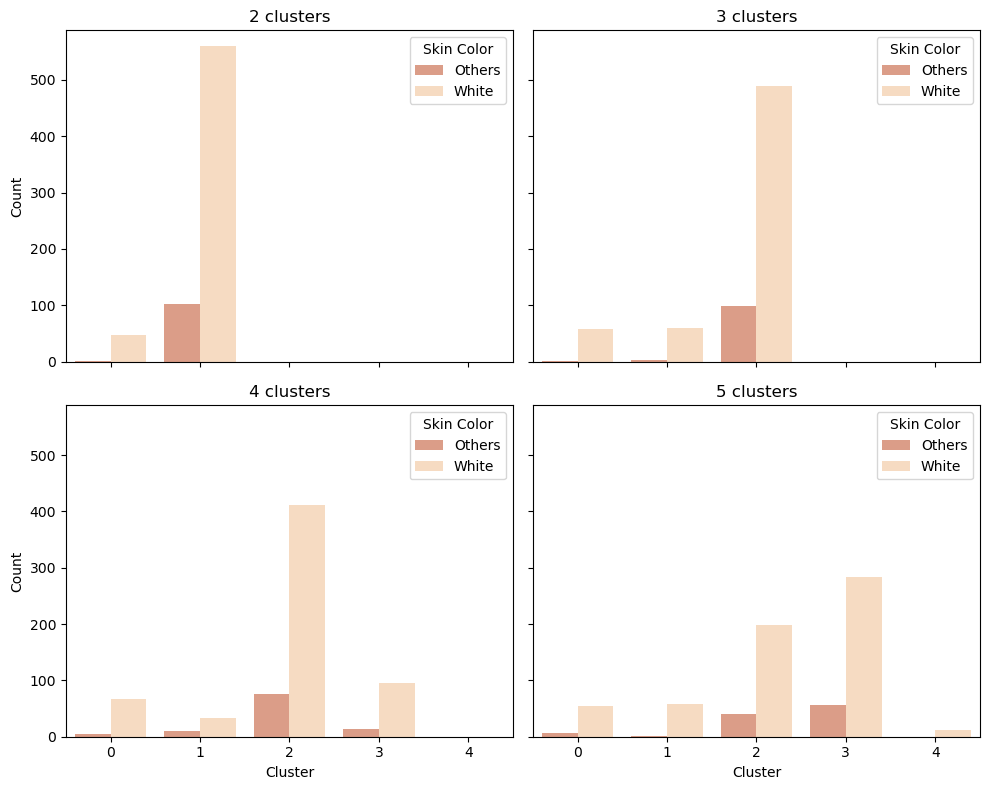

In [170]:

MIN_CLUSTERS = 2
MAX_CLUSTERS = 6

COLUMNS = 2
ROWS = math.ceil((MAX_CLUSTERS - MIN_CLUSTERS) / COLUMNS)
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10, 8), sharey=True, sharex=True)

# Définir un dictionnaire de couleurs pour les catégories
color_palette = {"White": "peachpuff", "Others": "darksalmon"}  # Vous pouvez ajouter ou modifier les couleurs ici

for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS):
    current_column = (n_clusters - MIN_CLUSTERS) % COLUMNS
    current_row = (n_clusters - MIN_CLUSTERS) // COLUMNS
    ax = axs[current_row, current_column]

    kmean = KMeans(n_clusters=n_clusters, max_iter=50, n_init=30).fit(Y)
    df_cluster = df.copy(deep=True)
    df_cluster['clusters'] = kmean.labels_
    df_cluster = df_cluster.groupby(['clusters', 'Skin Color']).size().reset_index(name='counts')

    sns.barplot(x='clusters', y='counts', hue='Skin Color', data=df_cluster, ax=ax, palette=color_palette)
    ax.set_title(f"{n_clusters} clusters")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


As observed, it's challenging to identify any meaningful clusters within the TF-IDF matrix.

We are now shifting our focus to sentiment analysis. We aim to determine whether we can distinguish a 'White' page from a page of another ethnicity based on sentiment analysis results. To start, we will use Vader for sentiment analysis

Vader provides three output values: positive_rate, negative_rate, and compound_rate. Positive_rate represents the percentage of the article's content that is deemed positive, while negative_rate reflects the percentage of negative content. The neutral_rate, on the other hand, signifies the proportion of neutral content within the article."

In [171]:

df['Positive_rate'] = [0 for i in range(len(df))]
df['Negative_rate'] = [0 for i in range (len(df))]
df['neutral_rate'] = [0 for i in range(len(df))]
df['Skin Color'] = df['Skin Color'].apply(lambda x : 'Others' if x != 'White' else x)


In [172]:
analyzer = SentimentIntensityAnalyzer()
for i in range(len(corpus)):
    with  open(corpus[i]) as page:
        page_score = analyzer.polarity_scores(page.read())
        df['Positive_rate'].iloc[i] = page_score.get('pos')
        df['Negative_rate'].iloc[i] = page_score.get('neg')
        df['neutral_rate'].iloc[i] = page_score.get('neu')


df.dropna()

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gp/T/ipykernel_94496/385667447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Positive_rate'].iloc[i] = page_score.get('pos')
/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gp/T/ipykernel_94496/385667447.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.039' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['Positive_rate'].iloc[i] = page_score.get('pos')
/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gp/T/ipykernel_94496/385667447.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

,People,Skin Color,Positive_rate,Negative_rate,neutral_rate
0,%C3%93engus_I_of_the_Picts,White,0.039,0.090,0.871
1,Abbas_I_of_Persia,Others,0.101,0.063,0.836
2,Adam_Smith,White,0.159,0.058,0.783
3,Adriaen_van_der_Donck,White,0.085,0.072,0.843
4,Agamemnon,White,0.066,0.114,0.820
...,...,...,...,...,...
706,Jimmy_Wales,White,0.079,0.014,0.907
707,Linus_Torvalds,White,0.092,0.019,0.889
708,Richard_Stallman,White,0.138,0.058,0.803
709,Tim_Berners-Lee,White,0.086,0.010,0.904


Our primary goal is to determine whether articles from a specific ethnic category tend to be more negative or positive on average compared to others. This is why we start by plotting each article based on its negative rate and positive rate. Subsequently, we will conduct a statistical analysis.

To represent the data, we will reduce the dimensionality to two using the PCA algorithm, allowing us to visualize them in two dimensions.

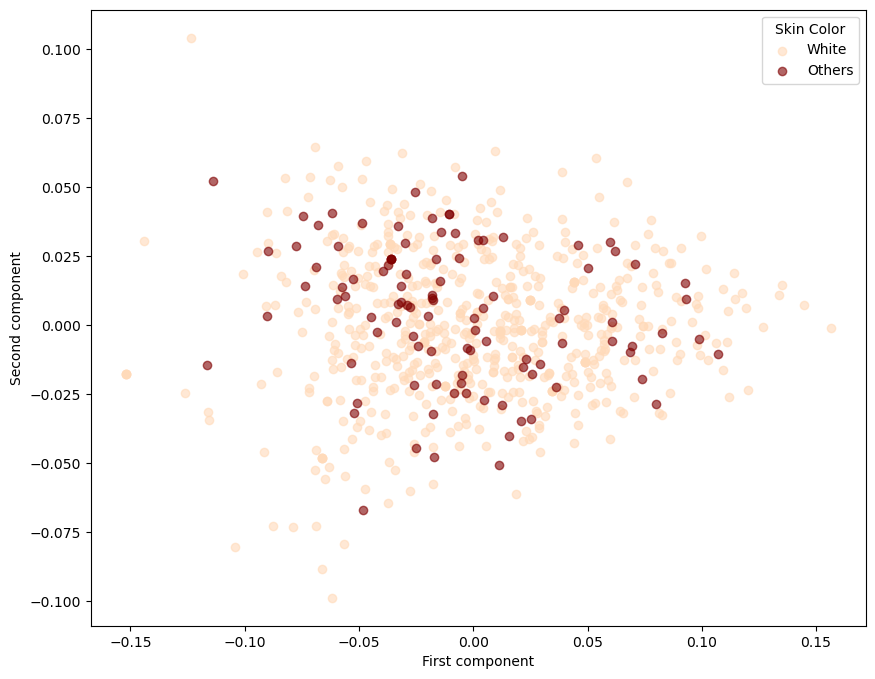

In [173]:

df_pca = PCA(n_components=2).fit(df[['Positive_rate','Negative_rate','neutral_rate']]).transform(df[['Positive_rate','Negative_rate','neutral_rate']])
df_pca = pd.DataFrame(df_pca, columns=['first_component', 'second_component'])
df['first_component'] = df_pca['first_component']
df['second_component'] = df_pca['second_component']

#plot the scatter graph
custom_colors = {'White': 'peachpuff', 'Others': 'maroon'}

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10, 8))

# Assign a custom color to each 'Skin Color' category
for skin_color in custom_colors:
    subset = df[df['Skin Color'] == skin_color]
    ax.scatter(subset['first_component'], subset['second_component'], 
               label=skin_color, c=custom_colors[skin_color], alpha=0.6)

# Set the axis labels
ax.set_xlabel("First component")
ax.set_ylabel("Second component")

# Add a legend
ax.legend(title='Skin Color')

# Show the plot
plt.show()


In [174]:
df[['Skin Color', 'Positive_rate', 'Negative_rate', 'neutral_rate']].groupby(by = ['Skin Color']).describe()

Positive_rate                                                   \
                   count      mean       std    min     25%    50%    75%   
Skin Color                                                                  
Others             103.0  0.093854  0.022310  0.048  0.0785  0.094  0.109   
White              608.0  0.094171  0.027663  0.030  0.0760  0.093  0.110   

                  Negative_rate            ...                neutral_rate  \
              max         count      mean  ...     75%    max        count   
Skin Color                                 ...                               
Others      0.161         103.0  0.074942  ...  0.1005  0.154        103.0   
White       0.192         608.0  0.067306  ...  0.0860  0.194        608.0   

                                                                     
                mean       std    min    25%    50%      75%    max  
Skin Color                                                           
Others      0.831282  0.038194  0.742  0.809  0.825  0.85100  0.925  
White       0.838530  0.041912  0.713  0.809  0.836  0.86725  0.965  

[2 rows x 24 columns]

One thing we can notice is that Wikipedia'articles are mostly written with a neutral tone.

let use a t-test to see if the null hypothesis that the average of White is greater or lower is significant.

In [175]:
stats.ttest_ind(df.loc[df['Skin Color'] == 'White']['neutral_rate'], df.loc[df['Skin Color'] == 'Others']['neutral_rate'] )

TtestResult(statistic=1.6431809250118232, pvalue=0.10078886906171104, df=709.0)

pvalue > 0.05 for the neutral rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

In [176]:
stats.ttest_ind(df.loc[df['Skin Color'] == 'White']['Positive_rate'], df.loc[df['Skin Color'] == 'Others']['Positive_rate'] )

TtestResult(statistic=0.1102480158106677, pvalue=0.9122438817995863, df=709.0)

pvalue > 0.05 for the positive rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

In [180]:
stats.ttest_ind(df.loc[df['Skin Color'] == 'White']['Negative_rate'], df.loc[df['Skin Color'] == 'Others']['Negative_rate'] )

TtestResult(statistic=-2.5330680591489454, pvalue=0.011521372409871456, df=709.0)

pvalue <0.05 for the negative rate, indicating a significant difference between articles categorized as 'white' and 'others' on average. However, it's worth noting that it's the articles attributed to the 'white' category that seem to be negatively impacted.

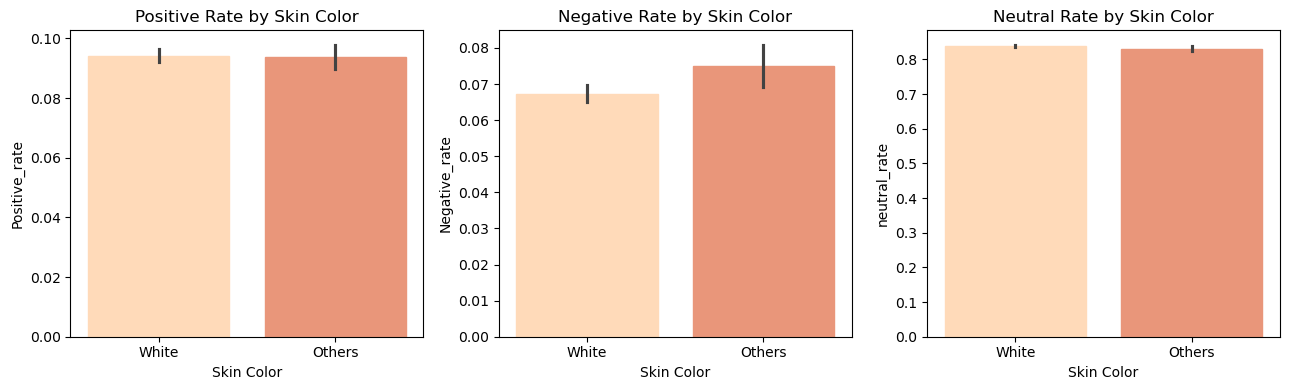

In [181]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# First bar plot for Positive_rate
ax1 = sns.barplot(x="Skin Color", y="Positive_rate", data=df, ax=axes[0])
ax1.set_title("Positive Rate by Skin Color")
for bar, skin_color in zip(ax1.patches, df["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Second bar plot for Negative_rate
ax2 = sns.barplot(x="Skin Color", y="Negative_rate", data=df, ax=axes[1])
ax2.set_title("Negative Rate by Skin Color")
for bar, skin_color in zip(ax2.patches, df["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Third bar plot for Neutral_rate
ax3 = sns.barplot(x="Skin Color", y="neutral_rate", data=df, ax=axes[2])
ax3.set_title("Neutral Rate by Skin Color")
for bar, skin_color in zip(ax3.patches, df["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

plt.tight_layout()
plt.show()

Now, let's attempt a more in-depth analysis. Firstly, the categories to which the articles belong can significantly influence Vader's sentiment evaluation. For instance, if an article discusses a character involved in a war, it's expected to be more negative compared to an article about an artist, for example. To mitigate this effect, we will perform perfect matching based on the categories.m

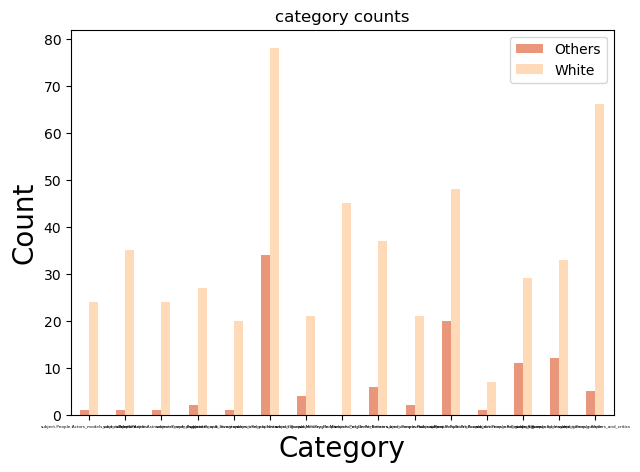

In [182]:
#let see the proportion of Skin Color in each categories.
people_skin_color['People'].map(lambda x : unquote(x,'utf-8'))
white_skin_color = people_skin_color.loc[people_skin_color['Skin Color'] == 'White']
other_skin_color = people_skin_color.loc[people_skin_color['Skin Color'] != 'White']
white_skin_color = white_skin_color[['Category','Skin Color']].groupby(['Category'], as_index = False).count()
other_skin_color = other_skin_color[['Category','Skin Color']].groupby(['Category'], as_index= False).count()
other_skin_color.columns = ['Category', 'Others']
white_skin_color.columns = ['Category', 'White']
category_df = other_skin_color.merge(white_skin_color, how='left', left_on=['Category'], right_on=['Category'])
category_df.index = category_df['Category']
pl = category_df.plot(kind='bar',figsize=[7,5],color=['darksalmon', 'peachpuff'], rot=0)
pl.set_title('category counts')
pl.set_ylabel('Count')
pl.set_xlabel('Category')
plt.xlabel('Category', fontsize=20)
plt.xticks(fontsize = 3)
plt.ylabel('Count', fontsize = 20)
plt.show()

In [183]:
#refaire le graph pour que l'on voit mieux les catégories

In [184]:
#remove cofounder category, we should try to match only white and other with same category : (sport player, politician,...)
#first we need to define a distance function for EXACT matching
def get_similarity(category_a, category_b):
    if (category_a.item() == category_b.item()): 
        return 1 
    else: 
        return 0    

In [185]:
#Create a bipartite graph(G = AUB) with A = papers with rebutal,
# and B = papers without rebutal and edges = similarity between nodes
a = people_skin_color[people_skin_color['Skin Color'] == 'White']
b = people_skin_color[people_skin_color['Skin Color'] != 'White']
G = nx.Graph()
for i in a[['Category']].iterrows(): 
    category_a = i[1]
    for  j in b [['Category']].iterrows():
        category_b = j[1]
        similarity = get_similarity(category_a, category_b)
        if (similarity == 1):
            G.add_weighted_edges_from([(i[0], j[0], similarity)])

In [186]:
# the layout of the matching is : row[n] is matched with row[n+1] 
matching = nx.min_weight_matching(G)
matched = list()
for i in matching: 
    matched = matched + [i[0]] + [i[1]]

In [187]:
matched_df = df.iloc[matched]


Let's create a new plot to visualize the distribution of 'White' and 'Others' categories after performing the matching.

To represent the data, we will reduce the dimensionality to two using the PCA algorithm, allowing us to visualize them as shown above."

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gp/T/ipykernel_94496/1649907754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_df['first_component'] = matched_df_pca['first_component']
/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gp/T/ipykernel_94496/1649907754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_df['second_component'] = matched_df_pca['second_component']


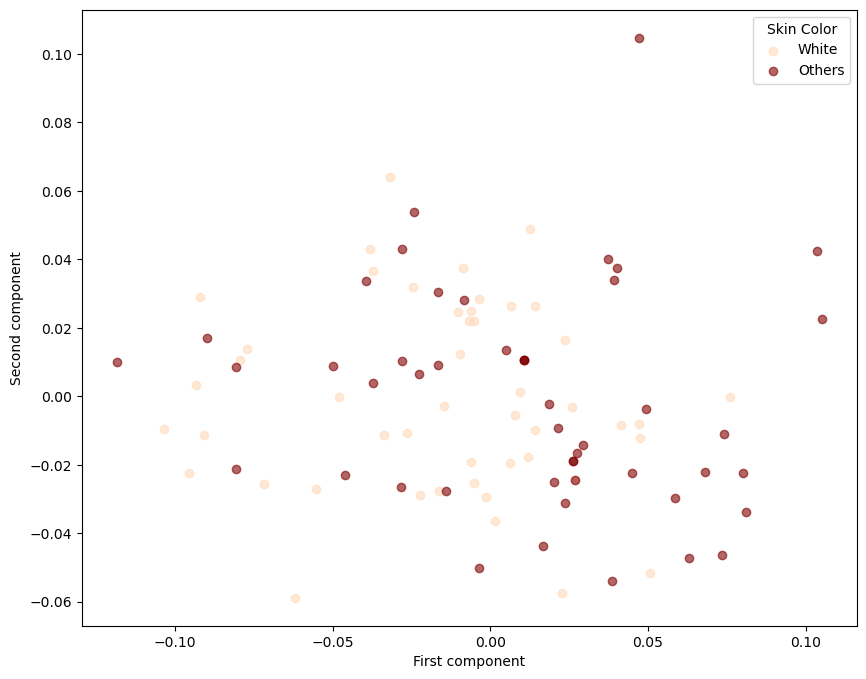

In [188]:
matched_df_pca = PCA(n_components=2).fit(matched_df[['Positive_rate','Negative_rate','neutral_rate']]).transform(matched_df[['Positive_rate','Negative_rate','neutral_rate']])
matched_df_pca = pd.DataFrame(matched_df_pca, columns=['first_component', 'second_component'])
matched_df['first_component'] = matched_df_pca['first_component']
matched_df['second_component'] = matched_df_pca['second_component']

custom_colors = {'White': 'peachpuff', 'Others': 'maroon'}

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10, 8))

# Assign a custom color to each 'Skin Color' category
for skin_color in custom_colors:
    subset = matched_df[matched_df['Skin Color'] == skin_color]
    ax.scatter(subset['first_component'], subset['second_component'], 
               label=skin_color, c=custom_colors[skin_color], alpha=0.6)

# Set the axis labels
ax.set_xlabel("First component")
ax.set_ylabel("Second component")

# Add a legend
ax.legend(title='Skin Color')

# Show the plot
plt.show()

In [189]:
matched_df[['Skin Color', 'Positive_rate', 'Negative_rate', 'neutral_rate']].groupby(by = ['Skin Color']).describe()

Positive_rate                                                    \
                   count      mean       std    min     25%    50%     75%   
Skin Color                                                                   
Others             103.0  0.093854  0.022310  0.048  0.0785  0.094  0.1090   
White              103.0  0.096573  0.030389  0.030  0.0755  0.094  0.1135   

                  Negative_rate            ...                neutral_rate  \
              max         count      mean  ...     75%    max        count   
Skin Color                                 ...                               
Others      0.161         103.0  0.074942  ...  0.1005  0.154        103.0   
White       0.189         103.0  0.076796  ...  0.0915  0.141        103.0   

                                                                    
                mean       std    min     25%    50%    75%    max  
Skin Color                                                          
Others      0.831282  0.038194  0.742  0.8090  0.825  0.851  0.925  
White       0.826709  0.040150  0.713  0.7985  0.821  0.854  0.927  

[2 rows x 24 columns]

let use a t-test to see if the null hypothesis that the average of White is greater or lower is significant.

In [190]:
stats.ttest_ind(matched_df.loc[matched_df['Skin Color'] == 'White']['neutral_rate'], matched_df.loc[matched_df['Skin Color'] == 'Others']['neutral_rate'] )

TtestResult(statistic=-0.8374806812654297, pvalue=0.40330250188115346, df=204.0)

pvalue > 0.05 for the neutral rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

In [191]:
stats.ttest_ind(matched_df.loc[matched_df['Skin Color'] == 'White']['Positive_rate'], matched_df.loc[matched_df['Skin Color'] == 'Others']['Positive_rate'] )

TtestResult(statistic=0.7318286269385977, pvalue=0.46511304582392554, df=204.0)

pvalue > 0.05 for the positive rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

In [192]:
stats.ttest_ind(matched_df.loc[matched_df['Skin Color'] == 'White']['Negative_rate'], matched_df.loc[matched_df['Skin Color'] == 'Others']['Negative_rate'] )

TtestResult(statistic=0.4573943986533421, pvalue=0.6478743266283186, df=204.0)

pvalue > 0.05 for the negative rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

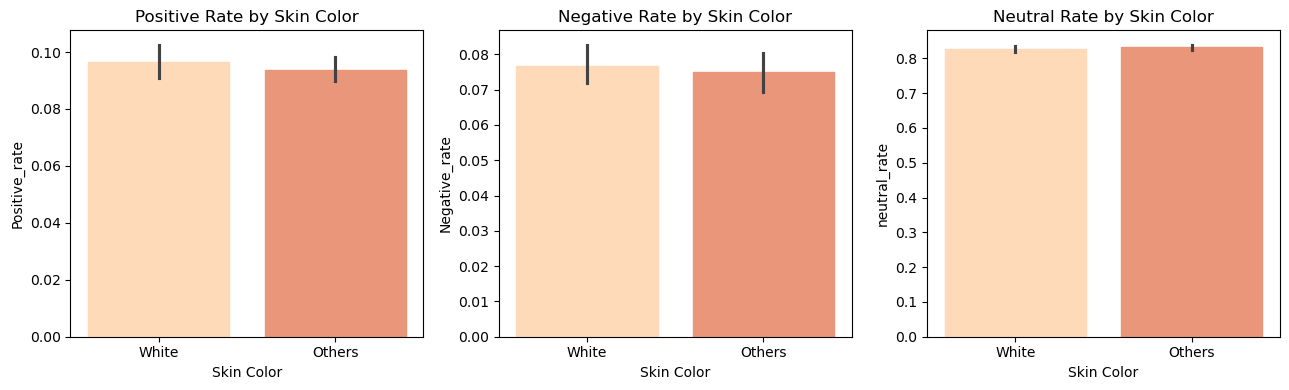

In [193]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# First bar plot for Positive_rate
ax1 = sns.barplot(x="Skin Color", y="Positive_rate", data=matched_df, ax=axes[0])
ax1.set_title("Positive Rate by Skin Color")
for bar, skin_color in zip(ax1.patches, matched_df["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Second bar plot for Negative_rate
ax2 = sns.barplot(x="Skin Color", y="Negative_rate", data=matched_df, ax=axes[1])
ax2.set_title("Negative Rate by Skin Color")
for bar, skin_color in zip(ax2.patches, matched_df["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Third bar plot for Neutral_rate
ax3 = sns.barplot(x="Skin Color", y="neutral_rate", data=matched_df, ax=axes[2])
ax3.set_title("Neutral Rate by Skin Color")
for bar, skin_color in zip(ax3.patches, matched_df["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

plt.tight_layout()
plt.show()

After performing the matching, it becomes clear that we can no longer claim that, on average, Wikipedia pages featuring 'White' individuals are more negative than those featuring 'Others.'
Conclusion: There is no statistically significant difference

Attempt the same analysis using an alternative Sentiment Analyzer. Because Vader was trained and is normally used for social networks.
We will employ a more adaptable NLP model named BERT

In [194]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [195]:
corpus_of_matched_people = matched_df['People'].apply(lambda x : dataFolder+x+'.txt')

For BERT, we utilize our mapping, and in addition, we will only consider the first 1024 characters of each article. This portion typically corresponds to the initial description or summary of a Wikipedia article, which is the most frequently read by Wikipedia users.

In [196]:
results = list()
for i in range(103):
    with  open(corpus_of_matched_people.iloc[i]) as page:
        page_token = tokenizer.encode(page.read()[0:1024], padding=True, truncation= True, max_length=512, return_tensors='pt')
        result = model(page_token)
        results.append(result.logits)

BERT produces a tensor that provides the probability of the article being rated as 1 star, 2 stars, ..., up to 5 stars.

In [197]:
data = [tensor.flatten().tolist() for tensor in results]
bert_df = pd.DataFrame(data, columns=['one_star', 'two_star','three_star','four_star','five_star'])
bert_df

,one_star,two_star,three_star,four_star,five_star
0,-0.152941,-0.127286,0.192592,0.370700,-0.060203
1,0.425771,0.194180,0.147253,0.045961,-0.565788
2,0.443068,-0.042277,0.185532,-0.071184,-0.300782
3,0.422728,0.111796,0.293913,-0.042682,-0.555804
4,0.051113,-0.100539,0.343199,0.155069,-0.208542
...,...,...,...,...,...
98,-0.219532,-0.014827,0.331935,0.450127,-0.270266
99,-0.050460,-0.092693,0.396280,0.417571,-0.433499
100,0.607802,-0.002104,-0.021656,-0.152647,-0.319824
101,0.786889,0.050795,0.025633,-0.303275,-0.485475


To represent the data, we will reduce the dimensionality to two using the PCA algorithm, allowing us to visualize them in two dimensions"

In [198]:
bert_reduced_pca = PCA(n_components=2).fit(bert_df).transform(bert_df)
bert_reduced_pca = pd.DataFrame(bert_reduced_pca, columns=['first_component', 'second_component'])


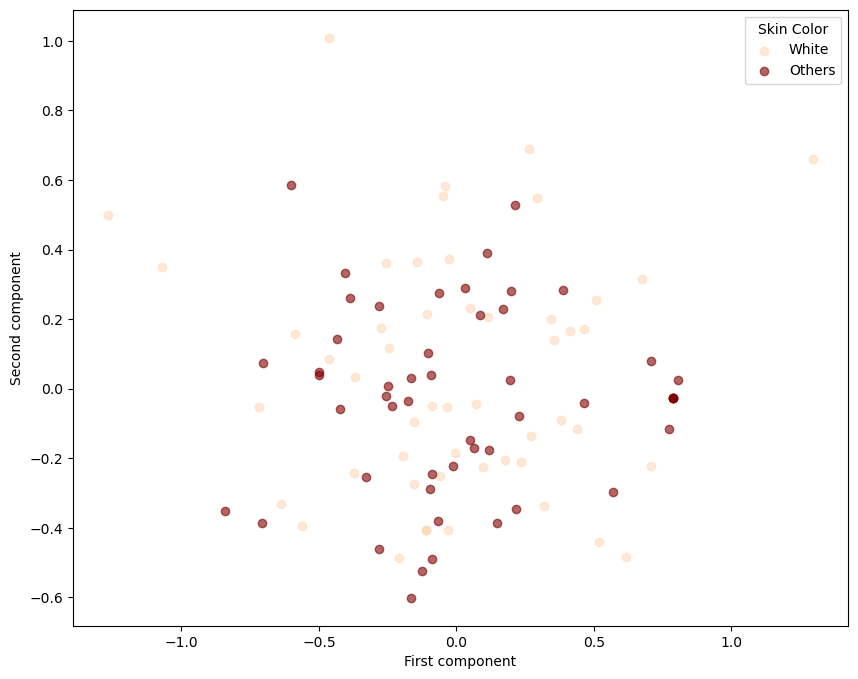

In [199]:
custom_colors = {'White': 'peachpuff', 'Others': 'maroon'}

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10, 8))

# Assign a custom color to each 'Skin Color' category
i = 0
for skin_color in custom_colors:
    subset = bert_reduced_pca[bert_reduced_pca.index %2 == i]
    i +=1
    ax.scatter(subset['first_component'], subset['second_component'], 
               label=skin_color, c=custom_colors[skin_color], alpha=0.6)

# Set the axis labels
ax.set_xlabel("First component")
ax.set_ylabel("Second component")

# Add a legend
ax.legend(title='Skin Color')

# Show the plot
plt.show()

We can observe that the data is still evenly distributed. However, let's conduct a statistical analysis to confirm

In [200]:
temp = list()
for i in range(len(bert_reduced_pca)):
    if (i%2==0):
        temp.append('White')
    else : 
        temp.append('Others')

bert_df['Skin_Color'] = temp
bert_reduced_pca['Skin Color'] = temp
bert_reduced_pca

,first_component,second_component,Skin Color
0,0.379871,-0.090009,White
1,-0.501516,0.038881,Others
2,-0.374266,-0.241325,White
3,-0.501385,0.048968,Others
4,0.072571,-0.043126,White
...,...,...,...
98,0.343576,0.200246,White
99,0.167793,0.229806,Others
100,-0.560487,-0.395961,White
101,-0.842179,-0.352391,Others


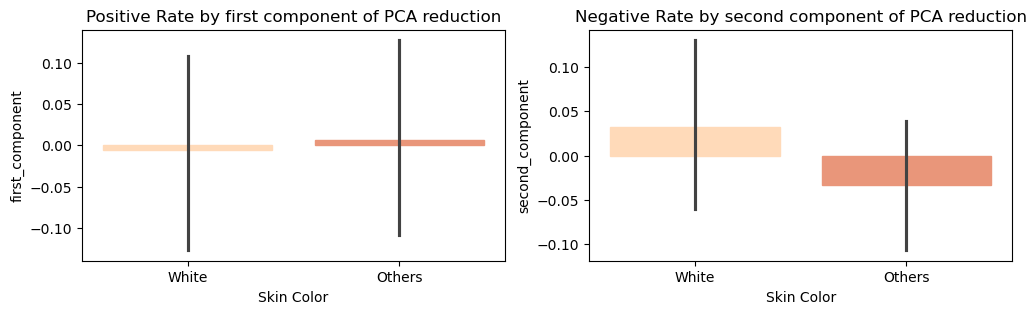

In [201]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# First bar plot for Positive_rate
ax1 = sns.barplot(x="Skin Color", y="first_component", data=bert_reduced_pca, ax=axes[0])
ax1.set_title("Positive Rate by first component of PCA reduction")
for bar, skin_color in zip(ax1.patches, bert_reduced_pca["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Second bar plot for Negative_rate
ax2 = sns.barplot(x="Skin Color", y="second_component", data=bert_reduced_pca, ax=axes[1])
ax2.set_title("Negative Rate by second component of PCA reduction")
for bar, skin_color in zip(ax2.patches, bert_reduced_pca["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

In [202]:
bert_df[['Skin_Color', 'one_star', 'two_star', 'three_star', 'four_star','five_star']].groupby(by = ['Skin_Color']).describe()

one_star                                                    \
              count      mean       std       min       25%       50%   
Skin_Color                                                              
Others         51.0  0.085048  0.316085 -0.488045 -0.134862  0.147852   
White          52.0  0.079370  0.339604 -1.087790 -0.130996  0.063097   

                               two_star            ... four_star            \
                 75%       max    count      mean  ...       75%       max   
Skin_Color                                         ...                       
Others      0.277430  0.786889     51.0 -0.044113  ...  0.310975  0.606256   
White       0.298535  0.780667     52.0 -0.013389  ...  0.341448  0.876125   

           five_star                                                    \
               count      mean       std       min       25%       50%   
Skin_Color                                                               
Others          51.0 -0.282565  0.254835 -0.956821 -0.467597 -0.352561   
White           52.0 -0.316407  0.295400 -1.156179 -0.489644 -0.261569   

                                
                 75%       max  
Skin_Color                      
Others     -0.075288  0.149885  
White      -0.106845  0.236157  

[2 rows x 40 columns]

Because there is a single categorical outcome and more than two continuous predictor variables, we will employ a logistic regression test

In [203]:
bert_df['Skin_Color'] = bert_df['Skin_Color'].apply(lambda x : 1 if x == 'White' else 0 )
mod = smf.logit(formula='Skin_Color ~  one_star + two_star + three_star + four_star + five_star ', data=bert_df)
res = mod.fit()
print(res.summary())



Optimization terminated successfully.
         Current function value: 0.601185
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Skin_Color   No. Observations:                  103
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            5
Date:                Tue, 19 Dec 2023   Pseudo R-squ.:                  0.1326
Time:                        15:53:57   Log-Likelihood:                -61.922
converged:                       True   LL-Null:                       -71.389
Covariance Type:            nonrobust   LLR p-value:                  0.001977
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4212      1.429     -2.394      0.017      -6.223      -0.620
one_star      14.0085      4.

In [204]:
stats.ttest_ind(bert_df.loc[bert_df.index %2 ==0]['one_star'], bert_df.loc[bert_df.index %2 == 1]['one_star'])

TtestResult(statistic=-0.08778967029241182, pvalue=0.9302176743218505, df=101.0)

In [205]:
stats.ttest_ind(bert_df.loc[bert_df.index %2 ==0]['two_star'], bert_df.loc[bert_df.index %2 == 1]['two_star'])

TtestResult(statistic=0.7898878989423502, pvalue=0.43144381379550223, df=101.0)

In [206]:
stats.ttest_ind(bert_df.loc[bert_df.index %2 ==0]['three_star'], bert_df.loc[bert_df.index %2 == 1]['three_star'])

TtestResult(statistic=1.7513432778169433, pvalue=0.08292255633680824, df=101.0)

In [207]:
stats.ttest_ind(bert_df.loc[bert_df.index %2 ==0]['four_star'], bert_df.loc[bert_df.index %2 ==1 ]['four_star'])

TtestResult(statistic=0.2737855644498147, pvalue=0.7848085422286928, df=101.0)

In [208]:
stats.ttest_ind(bert_df.loc[bert_df.index %2 ==0]['five_star'], bert_df.loc[bert_df.index %2 ==1 ]['five_star'])

TtestResult(statistic=-0.622018773912676, pvalue=0.5353311683715016, df=101.0)

As we can see, the p-values are very high, indicating that we cannot draw any conclusion regarding a connection between sentiment analysis and whether an article pertains to white or black